In [1]:
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
import pandas as pd
from pymilvus import connections, utility, Collection, FieldSchema, CollectionSchema, DataType
from tqdm import tqdm
from transformers import pipeline           # Hugging Face转换器
import networkx as nx                       # 网络图形可视化
import matplotlib.pyplot as plt
import json


实验说明：该实验使用和原本文献相同的超参数，和原文一样使用abstract进行embedding。投入bertopic的文本为abstract。目的是作为对照。

# TC = 0.5428, TD = 0.7136

In [2]:
# 设置文件路径
raw_csv_path ="../raw.csv"

# 读取CSV文件
def load_info():
    # 读取csv文件
    df = pd.read_csv(raw_csv_path)
    
    # 提取需要的列
    info = []
    for _, row in df.iterrows():
        abstract = row['abstract']
        try:
            year = int(row['pub_year'])
        except:
            year = np.nan
        # 这里只保留abstract和year，根据要求忽略doi, journal, citation
        info.append([abstract, year, None, None, None])  # None占位符用于与原代码结构保持一致
    
    # 创建DataFrame，保持与原代码相同的列结构
    info = pd.DataFrame(info, columns=['abstract', 'year', 'doi', 'journal', 'citation'])
    return info

# 加载数据
data_full = load_info()

# 移除缺失摘要的条目
data_full = data_full.dropna(subset=['abstract'])

# 提取摘要文本用于主题建模
docs = data_full.abstract.values

# 打印基本信息
print(f"数据总量: {len(data_full)}")
print(f"年份范围: {data_full['year'].min()} - {data_full['year'].max()}")

数据总量: 3000
年份范围: 2002 - 2025


In [ ]:
# from transformers import AutoTokenizer

# # 初始化tokenizer (使用BERT基础模型，您也可以根据需要换成其他模型)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# # 计算docs中每条数据的token数量
# token_counts = [len(tokenizer.encode(doc)) for doc in docs]

# # 计算统计信息
# total_tokens = sum(token_counts)
# avg_tokens = total_tokens / len(docs)
# max_tokens = max(token_counts)
# min_tokens = min(token_counts)

# # 打印结果
# print(f"总token数: {total_tokens}")
# print(f"平均每条数据token数: {avg_tokens:.2f}")
# print(f"最大token数: {max_tokens}")
# print(f"最小token数: {min_tokens}")
# print(f"超过512 token的数据比例: {sum(1 for x in token_counts if x > 512) / len(token_counts):.2%}")
# print(f"超过1024 token的数据比例: {sum(1 for x in token_counts if x > 1024) / len(token_counts):.2%}")

# # 如果您想查看更详细的分布，取消下面的注释
# plt.figure(figsize=(10, 6))
# plt.hist(token_counts, bins=50)
# plt.title('Token数量分布')
# plt.xlabel('Token数量')
# plt.ylabel('文档数量')
# plt.show()

In [4]:
# model instance
embedding_model = SentenceTransformer(
  'all-MiniLM-L6-v2',
  # 'all-mpnet-base-v2',
  # 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext',
  # 'dmis-lab/biobert-v1.1',
  # 'NeuML/pubmedbert-base-embeddings',
)

# embeddings = np.load('data/emb-covid-19-pubmedbert-base-embeddings.npy')
# print(type(embeddings), embeddings.shape)

# reduce dimensionality
umap_model = UMAP(
    n_neighbors = 15, n_components = 5, min_dist = 0.0, 
    metric = 'cosine', random_state = 34)
# cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size = 30, min_samples = 10,  
    metric = 'euclidean', cluster_selection_method = 'eom', 
    prediction_data = True)

# tokenize topics
vectorizer_model = CountVectorizer(stop_words = "english")
# create topic representation
ctfidf_model = ClassTfidfTransformer()
# fine tune with relevance
representation_model = MaximalMarginalRelevance(diversity = 0.2)
# all steps together
topic_model = BERTopic(
  embedding_model = embedding_model,    # Step 1 - Extract embeddings
  umap_model = umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model = hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model = vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model = ctfidf_model,          # Step 5 - Extract topic words        
  calculate_probabilities = True,        
  verbose = True,
  representation_model = representation_model # Diversify topic words
)

In [5]:
# 训练模型
topics, probs = topic_model.fit_transform(docs)

# topic_model.fit_transform(docs, embeddings=embeddings)

# 获取聚类结果
topic_info = topic_model.get_topic_info()
topic_info



Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2025-05-28 20:31:20,122 - BERTopic - Transformed documents to Embeddings
2025-05-28 20:31:35,523 - BERTopic - Reduced dimensionality
2025-05-28 20:31:35,702 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name,Representation,Representative_Docs
0,-1,618,-1_depression_students_study_anxiety,"[depression, students, study, anxiety, stress,...",[AIM: This study aimed to identify levels of d...
1,0,438,0_burnout_medical_residents_survey,"[burnout, medical, residents, survey, training...",[BACKGROUND AND RATIONALE: Residents work in e...
2,1,251,1_nursing_students_anxiety_simulation,"[nursing, students, anxiety, simulation, stres...",[The need for clinical placements for undergra...
3,2,194,2_covid_pandemic_anxiety_depression,"[covid, pandemic, anxiety, depression, symptom...",[BACKGROUND: The COVID-19 pandemic has serious...
4,3,160,3_patients_pain_cancer_depression,"[patients, pain, cancer, depression, anxiety, ...",[INTRODUCTION: Diagnosis of breast cancer is a...
5,4,135,4_drinking_motives_consequences_cannabis,"[drinking, motives, consequences, cannabis, sm...",[BACKGROUND: College students with depressive ...
6,5,123,5_intervention_anxiety_attachment_depression,"[intervention, anxiety, attachment, depression...",[BACKGROUND: Emerging adulthood is often assoc...
7,6,107,6_anxiety_rumination_self_phobia,"[anxiety, rumination, self, phobia, sensitivit...","[Using mediated and moderated regression, this..."
8,7,107,7_mental_students_stigma_seeking,"[mental, students, stigma, seeking, treatment,...",[BACKGROUND: Mental disorders are widespread a...
9,8,85,8_eating_weight_depression_health,"[eating, weight, depression, health, disorders...",[The aim of this paper was to identify the cha...


In [6]:
# info about all docs assigned to topics
documents = topic_model.get_document_info(docs) 

In [7]:
# ====================================
# 模块5: 模型评估
# 计算主题一致性(TC)和主题多样性(TD)指标
# ====================================
# 将每个主题下的文档合并为一个长文档
documents_per_topic = documents.groupby(['Topic'], as_index = False).agg({'Document': ' '.join})
# 对文档进行预处理
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)
# 构建文档分析器
analyzer = topic_model.vectorizer_model.build_analyzer()
# 获取每个文档的标记
tokens = [analyzer(doc) for doc in cleaned_docs]
# 构建主题词列表(每个主题取前10个关键词的第一个元素)
bertopic_topics = [
    [topicwords[0] for topicwords in topic_model.get_topic(i)[:10]]
    for i in range(len(set(topics)) - 1)]
# 计算主题一致性(Topic Coherence)
TC = Coherence(texts = tokens, topk = 10, measure = 'c_v').score({'topics': bertopic_topics}) 
# 计算主题多样性(Topic Diversity)
TD = TopicDiversity().score({'topics': bertopic_topics})
# print('TC = ', TC, 'TD = ', TD)
# 输出保留4位小数的指标值
print(f'TC = {TC:.4f}, TD = {TD:.4f}')


# TC = 0.6345, TD = 0.6741 covid

# TC = 0.5814, TD = 0.7824 depression



TC = 0.5428, TD = 0.7136


In [8]:
# ====================================
# 模块6: 主题探索和分析
# 对特定主题进行详细分析
# ====================================
# 选择一个感兴趣的主题进行分析
MY_TOPIC = 5
# 获取该主题的十个关键词
topic_model.get_topic(MY_TOPIC) 
# 获取分配给该主题的所有文档
assigned_docs = documents[documents.Topic == MY_TOPIC] 
# 打印该主题下所有文档的摘要
for abstract in assigned_docs.Document:
    print(abstract)
    print('---')

# 获取该主题的代表性文档
representative_docs = topic_model.get_representative_docs(MY_TOPIC)
# 获取代表性文档的引用信息
data_full[data_full.abstract == representative_docs[1]].iloc[0].citation
    
# 使用零样本分类器为主题分配标签
classifier = pipeline("zero-shot-classification", model = "facebook/bart-large-mnli")
# 将主题关键词组合成一个序列
sequence_to_classify =  " ".join([word for word, _ in topic_model.get_topic(MY_TOPIC)])
# 定义候选标签
candidate_labels = ["Psychometrics of depression"]
# 执行分类
classifier(sequence_to_classify, candidate_labels)

BACKGROUND: Approximately 20% of US adults identify as having a mental illness. Structural and other barriers prevent many people from receiving mental health services. Digital mental health apps that provide 24-hour, real-time access to human support may improve access to mental health services. However, information is needed regarding how and why people engage with licensed counselors through a digital, real-time, text-based mental health support app in nonexperimental settings. OBJECTIVE: This study aimed to evaluate how people engage with Counslr, a 24-hour, digital, mental health support app where users communicate in real time with human counselors through text messaging. Specifically, access patterns (eg, day of the week and time of session) and reasons for accessing the platform were examined. Furthermore, whether differences existed between session types (on-demand or scheduled) and membership types (education or noneducation) in regard to access patterns and why people access

{'sequence': 'intervention anxiety attachment depression therapists psychotherapy therapy cbt outcomes therapist',
 'labels': ['Psychometrics of depression'],
 'scores': [0.776483416557312]}

100%|██████████| 21/21 [00:00<00:00, 37.32it/s]
22it [00:09,  2.37it/s]


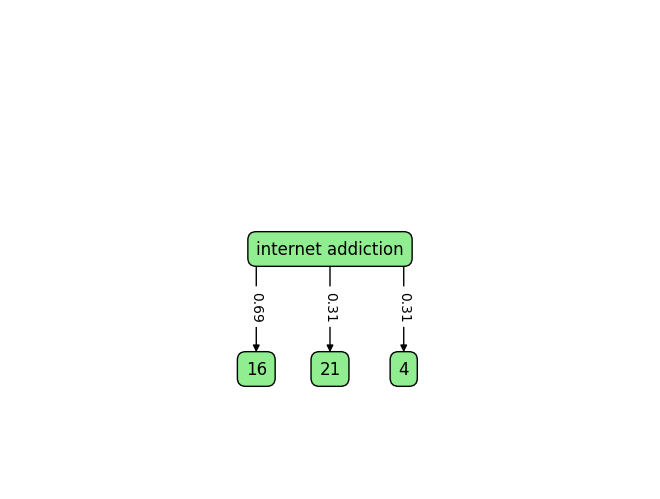

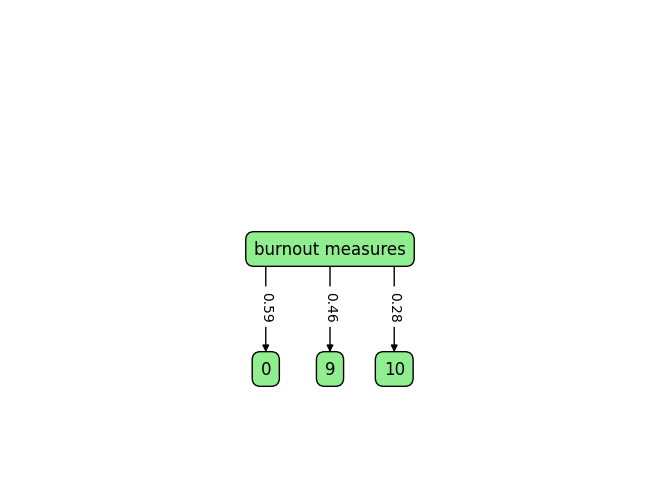

In [9]:
# ====================================
# 模块7: 结果可视化
# 使用多种方法可视化主题建模结果
# ====================================
# 1. 条形图 - 显示前六个主题的关键词
barchart = topic_model.visualize_barchart(top_n_topics = 6, n_words = 5, width = 400, title = "")
barchart.show()

# 2. 主题间关系图 - 展示主题之间的距离和关系
topic_model.visualize_topics().show()

# 3. 热力图 - 显示主题之间的相似度矩阵
topic_model.visualize_heatmap(n_clusters = 7)

# 4. 层次聚类 - 展示主题的层次结构
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics = hierarchical_topics)

# 5. 文档嵌入可视化 - 展示文档在空间中的分布
embeddings = embedding_model.encode(docs, show_progress_bar = False)
topic_model.visualize_documents(docs, embeddings = embeddings)   
topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, embeddings = embeddings) 
 
# 6. 时间序列分析 - 展示主题随时间变化的趋势
time = data_full.year.to_list() 
topics_over_time = topic_model.topics_over_time(docs, time)
topic_model.visualize_topics_over_time(topics_over_time, topics = [0, 4, 5, 20])

# 7. 主题相关性搜索 - 查找与特定关键词相关的主题
# 函数：绘制关键词与主题的相似度网络图
def draw_simil(keyword):
    # 找出与关键词最相关的3个主题及其相似度
    topicsF, similarity = topic_model.find_topics(keyword, top_n = 3)
    # 构建网络图的节点
    G = nx.DiGraph()
    G.add_node(-1)
    G.add_node(0)
    G.add_node(1)
    G.add_node(2)
    node_labels = dict(enumerate(topicsF))
    node_labels[-1] = keyword
    scale = (len(keyword) + 12) * 0.032
    x_offset = 0.25 * scale
    y_offset = -.5
    # 设置节点位置
    pos = {
        -1: (0, 0),
        0: (-x_offset * scale, y_offset),
        1: (0, y_offset),
        2: (x_offset * scale, y_offset)
    }
    # 绘制节点
    nx.draw(
        G, pos = pos, labels = node_labels, with_labels = True, node_shape = "s", 
        bbox = dict(facecolor = "lightgreen", edgecolor = 'black', boxstyle = 'round,pad=0.5'))
    
    # 构建边的图形(用于改变边的位置)
    H = nx.DiGraph()
    for i, sim_val in enumerate(similarity):
        H.add_edge(i + 3, i, label = round(sim_val, 2)) # 3->0, 4->1, 5->2
    y_offset = -.48
    # 设置边位置
    pos = {
        0: (-x_offset * scale, y_offset),
        1: (0, y_offset),
        2: (x_offset * scale, y_offset),
        3: (-x_offset * scale, 0),
        4: (0, 0),
        5: (x_offset * scale, 0)
    }
    edge_labels = nx.get_edge_attributes(H, "label")
    # 绘制边和标签
    nx.draw_networkx(H, labels = {}, node_color = "white", arrows = True, pos = pos)
    nx.draw_networkx_edge_labels(H, pos, edge_labels)
    # 设置图形边距
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    plt.show()

# 分析两个关键词与主题的相关性
draw_simil('internet addiction')
draw_simil('burnout measures')
